# Factor Analysis

Factor analysis is a method for automatically finding latent variables in a data set. It assumes that observed variables are actually a linear combination of a number of latent factors. Often, we are aiming to find a smaller number of factors that explain trends in our data.

This is how factor analysis differs from principal componant analysis. In PCA, the components are not interpretable, however, in factor analysis, we can see which observed variables are highly correlated with which factors and group observed variables according to which factors they are correlated with by looking at the loading. We can also see which factors are most important by their eiganvalues. Another technical difference between PCA and factor analysis is that in PCA, all the components are orthogonal but in factor analysis this does not need to be the case.

## Load Data

In [1]:
import pandas as pd
import numpy as np
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from scipy.stats import pointbiserialr, ttest_ind
import matplotlib.pyplot as plt
import pingouin as pg
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
wellness_df = pd.read_csv('./raw_data/wellness.csv')
wellness_df.head()


,Date,PlayerID,Fatigue,Soreness,Desire,Irritability,BedTime,WakeTime,SleepHours,SleepQuality,MonitoringScore,Pain,Illness,Menstruation,Nutrition,NutritionAdjustment,USGMeasurement,USG,TrainingReadiness
0,2018-07-21,1,3,3,2,3,23:00:00,07:00:00,8.00,2,13,No,No,Yes,Excellent,Yes,No,NaN,0%
1,2018-07-21,2,4,3,4,4,23:00:00,07:00:00,8.00,4,19,Yes,No,Yes,NaN,NaN,Yes,1.010,0%
2,2018-07-21,3,3,3,5,4,22:30:00,06:30:00,8.00,4,19,No,No,No,NaN,NaN,Yes,1.016,100%
3,2018-07-21,4,2,3,5,4,00:30:00,07:00:00,6.50,1,15,No,No,Yes,Excellent,Yes,Yes,1.025,95%
4,2018-07-21,5,5,3,4,4,23:45:00,07:00:00,7.25,4,20,No,No,No,Okay,Yes,Yes,1.022,100%


In [3]:
wellness_df.shape

(5011, 19)

To start with, we have 5011 wellness observations.

## Cleaning and Visualizing Data

### Fatigue

In [4]:
wellness_df['Fatigue'].value_counts()

4    2003
3    1721
2     642
5     301
1     187
6     150
7       7
Name: Fatigue, dtype: int64

Based on the codebook, 1 is most tired and 7 is most fresh. The scales are:
1 -> Exhausted
4 -> Average
7 -> Fresher than usual

Thus, the values above make sense with average being most common and 1 less than average being second most common. I think we should be good leaving the values as is here.

Text(0.5, 1.0, 'Distribution of Fatigue')

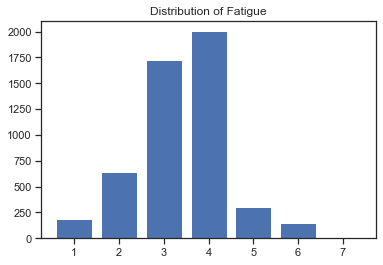

In [5]:
plt.bar(np.sort(wellness_df['Fatigue'].unique()), wellness_df['Fatigue'].value_counts().sort_index())
plt.title('Distribution of Fatigue')

### Soreness, Desire and Irritability

All of these columns are on the same scale as fatigue so we just need to make sure there are no missing values and we can continue using the raw values as with Fatigue.

In [6]:
wellness_df['Soreness'].value_counts()

4    1843
3    1831
2     737
5     280
1     176
6     128
7      16
Name: Soreness, dtype: int64

Text(0.5, 1.0, 'Distribution of Soreness')

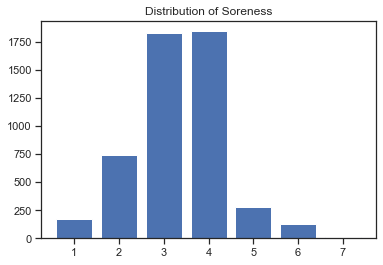

In [7]:
plt.bar(np.sort(wellness_df['Soreness'].unique()), wellness_df['Soreness'].value_counts().sort_index())
plt.title('Distribution of Soreness')

In [8]:
wellness_df['Desire'].value_counts()

4    3023
3     820
5     428
2     300
6     228
1     159
7      53
Name: Desire, dtype: int64

Text(0.5, 1.0, 'Distribution of Desire')

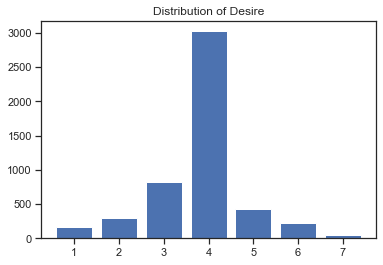

In [9]:
plt.bar(np.sort(wellness_df['Desire'].unique()), wellness_df['Desire'].value_counts().sort_index())
plt.title('Distribution of Desire')

In [10]:
wellness_df['Irritability'].value_counts()

4    3597
3     650
5     347
6     180
2     135
7      61
1      41
Name: Irritability, dtype: int64

Text(0.5, 1.0, 'Distribution of Irritability')

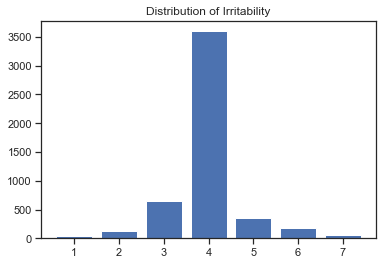

In [11]:
plt.bar(np.sort(wellness_df['Irritability'].unique()), wellness_df['Irritability'].value_counts().sort_index())
plt.title('Distribution of Irritability')

No missing values so all these columns can be used as is.

### Distribution Of Monitor Score Components

All of the monitor score components follow a normal distribution with a mean at the average value of 4. Soreness and Fatigue tend to have more lower values below 4.

### BedTime, WakeTime, and SleepHours

If we have SleepHours, it seems like we do not need BedTime and WakeTime as wellness would be affected by the amount of sleep and not the particular times players went to bed. Furthermore, most players go to bed and wake up at the same time. So, I will removed the `BedTime` and `Waketime` columns from the dataframe.

In [12]:
wellness_df = wellness_df.drop(columns=['BedTime', 'WakeTime'])
wellness_df.head()


,Date,PlayerID,Fatigue,Soreness,Desire,Irritability,SleepHours,SleepQuality,MonitoringScore,Pain,Illness,Menstruation,Nutrition,NutritionAdjustment,USGMeasurement,USG,TrainingReadiness
0,2018-07-21,1,3,3,2,3,8.00,2,13,No,No,Yes,Excellent,Yes,No,NaN,0%
1,2018-07-21,2,4,3,4,4,8.00,4,19,Yes,No,Yes,NaN,NaN,Yes,1.010,0%
2,2018-07-21,3,3,3,5,4,8.00,4,19,No,No,No,NaN,NaN,Yes,1.016,100%
3,2018-07-21,4,2,3,5,4,6.50,1,15,No,No,Yes,Excellent,Yes,Yes,1.025,95%
4,2018-07-21,5,5,3,4,4,7.25,4,20,No,No,No,Okay,Yes,Yes,1.022,100%


In [13]:
wellness_df['SleepHours'].mean()

8.661893833566154

In [14]:
wellness_df['SleepHours'].std()

1.418457325102741

Text(0.5, 1.0, 'Distribution of Sleep Hours')

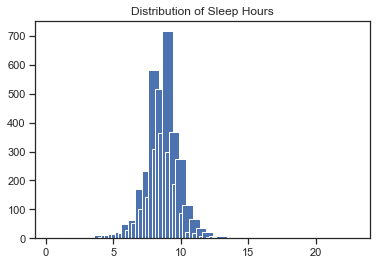

In [15]:
plt.bar(np.sort(wellness_df['SleepHours'].unique()), wellness_df['SleepHours'].value_counts().sort_index())
plt.title('Distribution of Sleep Hours')

The distribution is very peaked around 8.5 hours of sleep, similar to some of the other concentrated wellness variables above.

### Sleep Quality

In [16]:
wellness_df['SleepQuality'].value_counts()


4    2505
3    1037
5     508
2     386
6     242
1     193
7     140
Name: SleepQuality, dtype: int64

In [17]:
wellness_df['SleepQuality'].std()

1.1704873009267451

Text(0.5, 1.0, 'Distribution of Sleep Quality')

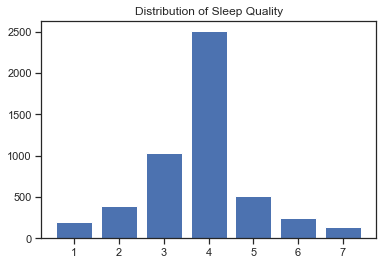

In [18]:
plt.bar(np.sort(wellness_df['SleepQuality'].unique()), wellness_df['SleepQuality'].value_counts().sort_index())
plt.title('Distribution of Sleep Quality')

Sleep quality has much more variance than sleep hours. It is slightly skewed to the left but not as much as Soreness and Fatigue are.

No missing values so we can leave this column as is. One interesting thought is how does this correlate with sleep duration?

#### Correlation With Sleep

In [19]:
wellness_df['SleepQuality'].corr(wellness_df['SleepHours'])

0.28179835513040297

It turns out sleep quality and the duration of sleep are not very correlated which is interesting. I would have thought that they would be, i.e. less sleep leads to worse quality and vice versa. Contextualizing this result in the context of these players being athletes makes sense. They are on a regimented schedule and get about the same amount of sleep each night, which we see from the distribution of sleep hours. So, any variance in their subjective sleep quality is likely related to other factors other than how long they slept.

### Pain

In [20]:
wellness_df['Pain'].value_counts()

No     4423
Yes     588
Name: Pain, dtype: int64

No missing values but we need to code this `Yes/No` column to take the values `1/0`

In [21]:
wellness_df['Pain'] = wellness_df['Pain'].map(dict(Yes=1, No=0))
wellness_df.head()


,Date,PlayerID,Fatigue,Soreness,Desire,Irritability,SleepHours,SleepQuality,MonitoringScore,Pain,Illness,Menstruation,Nutrition,NutritionAdjustment,USGMeasurement,USG,TrainingReadiness
0,2018-07-21,1,3,3,2,3,8.00,2,13,0,No,Yes,Excellent,Yes,No,NaN,0%
1,2018-07-21,2,4,3,4,4,8.00,4,19,1,No,Yes,NaN,NaN,Yes,1.010,0%
2,2018-07-21,3,3,3,5,4,8.00,4,19,0,No,No,NaN,NaN,Yes,1.016,100%
3,2018-07-21,4,2,3,5,4,6.50,1,15,0,No,Yes,Excellent,Yes,Yes,1.025,95%
4,2018-07-21,5,5,3,4,4,7.25,4,20,0,No,No,Okay,Yes,Yes,1.022,100%


### Illness

This should be trated the same as `Pain` assuming there are no missing values 

In [22]:
wellness_df['Illness'].value_counts()

No              4456
Slightly Off     421
Yes              134
Name: Illness, dtype: int64

It turns out there is a medium category of `Slightly Off` between `Yes` and `No`. So, I will code this column as a ordered categorical variable. I don't want to encode the difference between fully sick and being slightly off as the same as being slightly off and not sick. It seems the distance from not sick to slightly off is less than between slightly off and sick. So, instead of encoding sick as `2`, I will bump it up to `3`.

In [23]:
wellness_df['Illness'] = wellness_df['Illness'].map({'Yes': 3, 'Slightly Off': 1, 'No': 0})
wellness_df.head()


,Date,PlayerID,Fatigue,Soreness,Desire,Irritability,SleepHours,SleepQuality,MonitoringScore,Pain,Illness,Menstruation,Nutrition,NutritionAdjustment,USGMeasurement,USG,TrainingReadiness
0,2018-07-21,1,3,3,2,3,8.00,2,13,0,0,Yes,Excellent,Yes,No,NaN,0%
1,2018-07-21,2,4,3,4,4,8.00,4,19,1,0,Yes,NaN,NaN,Yes,1.010,0%
2,2018-07-21,3,3,3,5,4,8.00,4,19,0,0,No,NaN,NaN,Yes,1.016,100%
3,2018-07-21,4,2,3,5,4,6.50,1,15,0,0,Yes,Excellent,Yes,Yes,1.025,95%
4,2018-07-21,5,5,3,4,4,7.25,4,20,0,0,No,Okay,Yes,Yes,1.022,100%


### Menstruation

In [24]:
wellness_df['Menstruation'].value_counts()

No     4285
Yes     710
Name: Menstruation, dtype: int64

Update: it seems like `value_counts` does not show values that are NaN so I will need to check for that separatly

In [25]:
wellness_df[~ wellness_df['Menstruation'].isnull()].shape

(4995, 17)

17 observations is a small amount compared to 5011 overall so I will just remove the obervations that are missing Menstruation data.

In [26]:
wellness_df = wellness_df[~ wellness_df['Menstruation'].isnull()]

wellness_df.shape

(4995, 17)

This is a simple `Yes/No` column so we can encode it with integers 1 and 0.

In [27]:
wellness_df['Menstruation'] = wellness_df['Menstruation'].map(dict(Yes=1, No=0))
wellness_df.head()


,Date,PlayerID,Fatigue,Soreness,Desire,Irritability,SleepHours,SleepQuality,MonitoringScore,Pain,Illness,Menstruation,Nutrition,NutritionAdjustment,USGMeasurement,USG,TrainingReadiness
0,2018-07-21,1,3,3,2,3,8.00,2,13,0,0,1,Excellent,Yes,No,NaN,0%
1,2018-07-21,2,4,3,4,4,8.00,4,19,1,0,1,NaN,NaN,Yes,1.010,0%
2,2018-07-21,3,3,3,5,4,8.00,4,19,0,0,0,NaN,NaN,Yes,1.016,100%
3,2018-07-21,4,2,3,5,4,6.50,1,15,0,0,1,Excellent,Yes,Yes,1.025,95%
4,2018-07-21,5,5,3,4,4,7.25,4,20,0,0,0,Okay,Yes,Yes,1.022,100%


### Nutrition

In [28]:
wellness_df['Nutrition'].value_counts()


Excellent    2706
Okay         1394
Poor           63
Name: Nutrition, dtype: int64

In [29]:
wellness_df[wellness_df['Nutrition'].isnull()].shape


(832, 17)

#### Impute By Sampling From Distribution

There are a pretty solid amont of missing values but it would be nice to still include `Nutrition` in our analysis so I will resample the distribution to fill in missing values.

In [30]:
normalized_nutrition_value_counts = wellness_df['Nutrition'].value_counts(normalize=True)
missing_nutrition_indicies = wellness_df['Nutrition'].isnull()
wellness_df.loc[missing_nutrition_indicies, 'Nutrition'] = np.random.choice(normalized_nutrition_value_counts.index, size=len(wellness_df[missing_nutrition_indicies]), p=normalized_nutrition_value_counts.values)
wellness_df.head()


,Date,PlayerID,Fatigue,Soreness,Desire,Irritability,SleepHours,SleepQuality,MonitoringScore,Pain,Illness,Menstruation,Nutrition,NutritionAdjustment,USGMeasurement,USG,TrainingReadiness
0,2018-07-21,1,3,3,2,3,8.00,2,13,0,0,1,Excellent,Yes,No,NaN,0%
1,2018-07-21,2,4,3,4,4,8.00,4,19,1,0,1,Okay,NaN,Yes,1.010,0%
2,2018-07-21,3,3,3,5,4,8.00,4,19,0,0,0,Excellent,NaN,Yes,1.016,100%
3,2018-07-21,4,2,3,5,4,6.50,1,15,0,0,1,Excellent,Yes,Yes,1.025,95%
4,2018-07-21,5,5,3,4,4,7.25,4,20,0,0,0,Okay,Yes,Yes,1.022,100%


Make sure the imputation worked by looking for missing values again.

In [31]:
wellness_df[wellness_df['Nutrition'].isnull()].shape


(0, 17)

In [32]:
wellness_df['Nutrition'].value_counts()

Excellent    3279
Okay         1640
Poor           76
Name: Nutrition, dtype: int64

I will encode this as a ordered categorical variable with equal space between categories

In [33]:
wellness_df['Nutrition'] = wellness_df['Nutrition'].map({'Excellent': 3, 'Okay': 2, 'Poor': 1})
wellness_df.head()


,Date,PlayerID,Fatigue,Soreness,Desire,Irritability,SleepHours,SleepQuality,MonitoringScore,Pain,Illness,Menstruation,Nutrition,NutritionAdjustment,USGMeasurement,USG,TrainingReadiness
0,2018-07-21,1,3,3,2,3,8.00,2,13,0,0,1,3,Yes,No,NaN,0%
1,2018-07-21,2,4,3,4,4,8.00,4,19,1,0,1,2,NaN,Yes,1.010,0%
2,2018-07-21,3,3,3,5,4,8.00,4,19,0,0,0,3,NaN,Yes,1.016,100%
3,2018-07-21,4,2,3,5,4,6.50,1,15,0,0,1,3,Yes,Yes,1.025,95%
4,2018-07-21,5,5,3,4,4,7.25,4,20,0,0,0,2,Yes,Yes,1.022,100%


### NutritionAdjustment

In [34]:
wellness_df['NutritionAdjustment'].value_counts()

Yes             3718
No               438
I Don't Know      99
Name: NutritionAdjustment, dtype: int64

In [35]:
wellness_df[wellness_df['NutritionAdjustment'].isnull()].shape

(740, 17)

We could map all missing values for nutrition adjustment to the "I don't know" value but then we would have more "I don't knows" than "No". How do we encode this?

Since there are so many missing values, I will remove the nutrition columns for now

In [36]:
wellness_df = wellness_df.drop(columns=['NutritionAdjustment'])
wellness_df.head()


,Date,PlayerID,Fatigue,Soreness,Desire,Irritability,SleepHours,SleepQuality,MonitoringScore,Pain,Illness,Menstruation,Nutrition,USGMeasurement,USG,TrainingReadiness
0,2018-07-21,1,3,3,2,3,8.00,2,13,0,0,1,3,No,NaN,0%
1,2018-07-21,2,4,3,4,4,8.00,4,19,1,0,1,2,Yes,1.010,0%
2,2018-07-21,3,3,3,5,4,8.00,4,19,0,0,0,3,Yes,1.016,100%
3,2018-07-21,4,2,3,5,4,6.50,1,15,0,0,1,3,Yes,1.025,95%
4,2018-07-21,5,5,3,4,4,7.25,4,20,0,0,0,2,Yes,1.022,100%


### USG

`USGMeasirement` is just a flag that tells us whether there is a value for USG on that row so it does not prodive us any useful information we could not get from just looking at the `USG` column. So, I will drop it.

In [37]:
wellness_df = wellness_df.drop(columns=['USGMeasurement'])


In [38]:
wellness_df[wellness_df['USG'].isnull()].shape


(4370, 15)

There are so many missing measuresments for `USG` that I don't think we could do anything over than dropping it.

In [39]:
wellness_df = wellness_df.drop(columns=['USG'])


### TrainingReadiness

In [40]:
wellness_df['TrainingReadiness'].value_counts()

100%    1434
0%      1004
90%      641
95%      590
85%      293
80%      226
75%      201
70%      152
65%      111
50%       72
60%       70
55%       52
35%       26
45%       23
25%       17
30%       17
40%       16
20%       14
15%       14
10%       11
5%        11
Name: TrainingReadiness, dtype: int64

In [41]:
wellness_df[wellness_df['TrainingReadiness'].isnull()].shape

(0, 14)

Training readiness has no missing values and is expressed as percentages. I can map this to integers.

In [42]:
wellness_df['TrainingReadiness'] = wellness_df.apply(lambda row: int(row['TrainingReadiness'][0:-1]), axis=1)
wellness_df.head()


,Date,PlayerID,Fatigue,Soreness,Desire,Irritability,SleepHours,SleepQuality,MonitoringScore,Pain,Illness,Menstruation,Nutrition,TrainingReadiness
0,2018-07-21,1,3,3,2,3,8.00,2,13,0,0,1,3,0
1,2018-07-21,2,4,3,4,4,8.00,4,19,1,0,1,2,0
2,2018-07-21,3,3,3,5,4,8.00,4,19,0,0,0,3,100
3,2018-07-21,4,2,3,5,4,6.50,1,15,0,0,1,3,95
4,2018-07-21,5,5,3,4,4,7.25,4,20,0,0,0,2,100


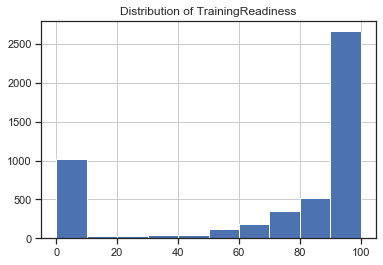

In [43]:
wellness_df['TrainingReadiness'].hist()
plt.title('Distribution of TrainingReadiness')
plt.show()

Training readiness has a interesting distribution where most players are 100% ready but the second most common response is close to 0. We also see a tail to the left of 100% with a small number of player tending down to about 50% readiness.

It is interesting that most players see themselves as completely ready or not at all ready to train. I wonder what casues the players to be 0% ready to train? Is there are correlation to one of the binary variables like illness? If we look at those who responded with training readiness < 10%, what do the distributions for the wellness items look like?

In [44]:
low_readiness_df = wellness_df[wellness_df['TrainingReadiness'] <= 10]
high_readiness_df = wellness_df[wellness_df['TrainingReadiness'] >= 80]

In [45]:
low_readiness_df['MonitoringScore'].mean()

17.680311890838208

In [46]:
low_readiness_df['MonitoringScore'].std()

3.908857022161638

In [47]:
high_readiness_df['MonitoringScore'].mean()

18.78831658291457

In [48]:
high_readiness_df['MonitoringScore'].std()

3.589759467852359

Text(0.5, 1.0, 'Distribution of Monitor Score for Low Training Readiness')

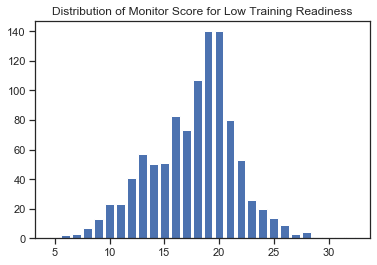

In [49]:
plt.bar(np.sort(low_readiness_df['MonitoringScore'].unique()), low_readiness_df['MonitoringScore'].value_counts().sort_index())
plt.title('Distribution of Monitor Score for Low Training Readiness')


Text(0.5, 1.0, 'Distribution of Monitor Score for High Training Readiness')

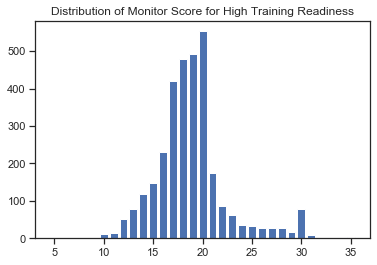

In [50]:
plt.bar(np.sort(high_readiness_df['MonitoringScore'].unique()), high_readiness_df['MonitoringScore'].value_counts().sort_index())
plt.title('Distribution of Monitor Score for High Training Readiness')

#### Is The Difference Significant?

The monitoring score for those who reported a low monitoring score seems to be lower than the mean for those who reported a high monitoring score, but, is the difference significant?

In [51]:
ttest_ind(low_readiness_df['MonitoringScore'], high_readiness_df['MonitoringScore'])

Ttest_indResult(statistic=-8.409875700037977, pvalue=5.552492748622289e-17)

We see that the difference in the means is significant. As we would expect, those who report that their training readiness is low tend to report lower monitor scores.

In [52]:
wellness_df['MonitoringScore'].corr(wellness_df['TrainingReadiness'])


0.13709833678544753

However, the effect size is weak, as we can see from the mean differences and the low correlation between Monitoring Score and Training Readiness.

### Monitoring Score

This is an aggregation of the 5 scale values. We could either use this or the 5 scales on their own but it would not be appropriate to use both. We are trying to see if our data can be represented as latent factors so we should ignore this summary column and see if the columns that it is made from are actually all related.

In [53]:
wellness_df = wellness_df.drop(columns=['MonitoringScore'])
wellness_df.head()


,Date,PlayerID,Fatigue,Soreness,Desire,Irritability,SleepHours,SleepQuality,Pain,Illness,Menstruation,Nutrition,TrainingReadiness
0,2018-07-21,1,3,3,2,3,8.00,2,0,0,1,3,0
1,2018-07-21,2,4,3,4,4,8.00,4,1,0,1,2,0
2,2018-07-21,3,3,3,5,4,8.00,4,0,0,0,3,100
3,2018-07-21,4,2,3,5,4,6.50,1,0,0,1,3,95
4,2018-07-21,5,5,3,4,4,7.25,4,0,0,0,2,100


In [54]:
wellness_df.shape


(4995, 13)

After all my cleaning, I am left with 4995 observations and 11 observed variables for factor analysis (date and player id are not useful in this case.

In [55]:
wellness_df.columns

Index(['Date', 'PlayerID', 'Fatigue', 'Soreness', 'Desire', 'Irritability',
       'SleepHours', 'SleepQuality', 'Pain', 'Illness', 'Menstruation',
       'Nutrition', 'TrainingReadiness'],
      dtype='object')

### Repeated Measures Correlations

In [56]:
test_wellness_df = wellness_df.copy()

In [57]:
for i in test_wellness_df.columns:
    if i == 'Date' or i == 'PlayerID':
        continue
        
    for j in wellness_df.columns:
        if j == 'Date' or j == 'PlayerID' or i == j:
            continue
            
        print('Repeated Measures Correlation Result for {} and {}'.format(i, j))
        print(pg.rm_corr(data=wellness_df, x=i, y=j, subject='PlayerID'))

Repeated Measures Correlation Result for Fatigue and Soreness
             r   dof           pval        CI95%  power
rm_corr  0.425  4977  4.349049e-218  [0.4, 0.45]    1.0
Repeated Measures Correlation Result for Fatigue and Desire
             r   dof           pval         CI95%  power
rm_corr  0.491  4977  2.047966e-300  [0.47, 0.51]    1.0
Repeated Measures Correlation Result for Fatigue and Irritability
             r   dof           pval         CI95%  power
rm_corr  0.382  4977  5.424256e-173  [0.36, 0.41]    1.0
Repeated Measures Correlation Result for Fatigue and SleepHours
             r   dof          pval         CI95%  power
rm_corr  0.201  4977  2.500877e-46  [0.17, 0.23]    1.0
Repeated Measures Correlation Result for Fatigue and SleepQuality
             r   dof           pval        CI95%  power
rm_corr  0.423  4977  6.015440e-215  [0.4, 0.45]    1.0
Repeated Measures Correlation Result for Fatigue and Pain


//anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
//anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


             r   dof      pval           CI95%  power
rm_corr -0.036  4977  0.011026  [-0.06, -0.01]   0.72
Repeated Measures Correlation Result for Fatigue and Illness
             r   dof          pval           CI95%  power
rm_corr -0.119  4977  3.045770e-17  [-0.15, -0.09]    1.0
Repeated Measures Correlation Result for Fatigue and Menstruation
             r   dof      pval          CI95%  power
rm_corr  0.006  4977  0.665409  [-0.02, 0.03]  0.072
Repeated Measures Correlation Result for Fatigue and Nutrition
             r   dof          pval         CI95%  power
rm_corr  0.133  4977  3.602627e-21  [0.11, 0.16]    1.0
Repeated Measures Correlation Result for Fatigue and TrainingReadiness
             r   dof          pval         CI95%  power
rm_corr  0.158  4977  2.685135e-29  [0.13, 0.19]    1.0
Repeated Measures Correlation Result for Soreness and Fatigue
             r   dof           pval        CI95%  power
rm_corr  0.425  4977  4.349030e-218  [0.4, 0.45]    1.0
Repeated Me

             r   dof          pval        CI95%  power
rm_corr  0.231  4977  2.345194e-61  [0.2, 0.26]    1.0
Repeated Measures Correlation Result for SleepQuality and Irritability
             r   dof           pval         CI95%  power
rm_corr  0.307  4977  6.799322e-109  [0.28, 0.33]    1.0
Repeated Measures Correlation Result for SleepQuality and SleepHours
             r   dof          pval         CI95%  power
rm_corr  0.269  4977  4.751244e-83  [0.24, 0.29]    1.0
Repeated Measures Correlation Result for SleepQuality and Pain
             r   dof      pval          CI95%  power
rm_corr -0.022  4977  0.125065  [-0.05, 0.01]  0.335
Repeated Measures Correlation Result for SleepQuality and Illness
             r   dof          pval           CI95%  power
rm_corr -0.087  4977  9.286735e-10  [-0.11, -0.06]    1.0
Repeated Measures Correlation Result for SleepQuality and Menstruation
             r   dof      pval          CI95%  power
rm_corr -0.001  4977  0.962367  [-0.03, 0.03]   0

             r   dof          pval         CI95%  power
rm_corr  0.101  4977  8.303311e-13  [0.07, 0.13]    1.0
Repeated Measures Correlation Result for TrainingReadiness and Desire
             r   dof           pval        CI95%  power
rm_corr  0.324  4977  6.993504e-122  [0.3, 0.35]    1.0
Repeated Measures Correlation Result for TrainingReadiness and Irritability
             r   dof          pval         CI95%  power
rm_corr  0.139  4977  5.020746e-23  [0.11, 0.17]    1.0
Repeated Measures Correlation Result for TrainingReadiness and SleepHours
             r   dof      pval           CI95%  power
rm_corr -0.036  4977  0.010345  [-0.06, -0.01]  0.727
Repeated Measures Correlation Result for TrainingReadiness and SleepQuality
             r   dof          pval        CI95%  power
rm_corr  0.073  4977  2.272747e-07  [0.05, 0.1]  0.999
Repeated Measures Correlation Result for TrainingReadiness and Pain
            r   dof      pval          CI95%  power
rm_corr -0.01  4977  0.486946 

#### Correlated Measures

* Fatigue and Soreness (0.425)  
* Fatigue and Desire (0.491)  
* Fatigue and Irritability (0.382)  
* Fatigue and Sleep Quality (0.423)  
* Soreness and Desire (0.379)
* Desire and Irritability (0.491)
* Desire and Soreness (0.379)
* Desire and TrainingReadiness (0.324)
* Irritability and SleepQuality (0.307)

The elements of the monitor score are all correlated with eachother which is further support that it is measuring the same latent variable. It is further interesting that nothing is correlated to Sleep Hours but measures such as Fatigue and Irritability are correlated with Sleep Quality. So sleep quality seems to be a better measure of one's sleeps over their sleep hours. At first, I thought this was because these athletes probably sleep for the same amount of time each night but that us not the case. The SD of Sleep Hours is 1.42 but it is only 1.17 for Sleep Quality. So Sleep Hours has more variance but is still not a good measure for things releated to sleep such as fatigue and Irritability.

I wonder how exactly Sleep Hours is computed. For example, when you "go to bed" is not when you fall asleep. Is sleep measure by bedtime and wake time or by tracking the acutal time one falls asleep or wakes up.

## Factor Analysis

In [58]:
wellness_df.head()

,Date,PlayerID,Fatigue,Soreness,Desire,Irritability,SleepHours,SleepQuality,Pain,Illness,Menstruation,Nutrition,TrainingReadiness
0,2018-07-21,1,3,3,2,3,8.00,2,0,0,1,3,0
1,2018-07-21,2,4,3,4,4,8.00,4,1,0,1,2,0
2,2018-07-21,3,3,3,5,4,8.00,4,0,0,0,3,100
3,2018-07-21,4,2,3,5,4,6.50,1,0,0,1,3,95
4,2018-07-21,5,5,3,4,4,7.25,4,0,0,0,2,100


### Averaging Over Different Dates

We cannot perform factor analysis using data gathered at different dates. So for each player, we need to average all their values. In doing so, we can interpret most columns as "Average X", i.e. "Average Sleep Hours". However, we cannot do this for the binary categorical columns. We could instead interpret these as probabilities, i.e., probability of being Ill.

#### Question:

Why is this? Is it because the observations for a given individual will not be independent over many different days?

In [59]:
wellness_df = wellness_df.drop(columns=['Date'])
full_wellness_df = wellness_df.copy() # Save full df for later
wellness_df = wellness_df.groupby('PlayerID',as_index = False).mean()
wellness_df


,PlayerID,Fatigue,Soreness,Desire,Irritability,SleepHours,SleepQuality,Pain,Illness,Menstruation,Nutrition,TrainingReadiness
0,1,2.671924,3.302839,2.479495,3.936909,8.715300,3.611987,0.025237,0.151420,0.157729,2.943218,21.435331
1,2,3.779762,3.276786,4.113095,4.151786,9.053571,4.122024,0.205357,0.044643,0.187500,2.669643,11.651786
2,3,3.350725,3.176812,3.455072,3.979710,7.879710,3.913043,0.026087,0.000000,0.118841,2.982609,98.115942
3,4,3.305195,3.542208,3.935065,3.668831,8.266234,2.954545,0.006494,0.016234,0.146104,2.925325,66.996753
4,5,3.803089,3.814672,4.324324,3.965251,7.925676,3.841699,0.316602,0.254826,0.111969,2.050193,65.637066
5,6,3.694656,3.438931,3.961832,3.942748,8.471374,3.984733,0.003817,0.057252,0.141221,2.740458,67.156489
6,7,3.073314,3.087977,3.797654,3.697947,9.212610,3.862170,0.070381,0.096774,0.131965,2.888563,93.460411
7,8,3.737705,3.537705,3.734426,4.367213,8.194262,4.016393,0.255738,0.708197,0.072131,2.531148,53.704918
8,9,4.877828,4.565611,4.886878,4.914027,9.160633,4.900452,0.004525,0.058824,0.104072,2.479638,77.104072
9,10,2.954683,2.978852,3.794562,3.824773,8.374622,2.933535,0.725076,0.595166,0.211480,2.513595,74.244713


Now that we have averaged over all the days for each player, we can drop the player id column.

In [60]:
player_id_series = wellness_df['PlayerID'] # Also save this for later
wellness_df = wellness_df.drop(columns=['PlayerID'])


In [61]:
wellness_df.shape

(17, 11)

We see that we have averaged over the 17 players in the dataset

### Correlations

Note, I am not sure if we should be taking correlations of aggregated values but when the aggregated correlation is high, the repreated measures correlation is also high. The general paterns we see in the correlation matrix below are apparent in the 'more correct' repeated measures correlation matrix.

In [62]:
wellness_df.corr()

,Fatigue,Soreness,Desire,Irritability,SleepHours,SleepQuality,Pain,Illness,Menstruation,Nutrition,TrainingReadiness
Fatigue,1.000000,0.864415,0.839981,0.872072,0.197166,0.793575,-0.149257,-0.168557,-0.350946,-0.321372,0.057665
Soreness,0.864415,1.000000,0.661108,0.805039,0.057078,0.681841,-0.168149,-0.179042,-0.177611,-0.408814,-0.101565
Desire,0.839981,0.661108,1.000000,0.580191,0.238104,0.592546,0.020143,-0.176135,-0.281295,-0.373658,0.229256
Irritability,0.872072,0.805039,0.580191,1.000000,0.198796,0.807746,-0.055961,0.045648,-0.275293,-0.205454,-0.082904
SleepHours,0.197166,0.057078,0.238104,0.198796,1.000000,0.401260,-0.297852,-0.357908,-0.025995,0.043886,0.007867
SleepQuality,0.793575,0.681841,0.592546,0.807746,0.401260,1.000000,-0.302088,-0.277461,-0.335666,-0.051985,0.035654
Pain,-0.149257,-0.168149,0.020143,-0.055961,-0.297852,-0.302088,1.000000,0.739189,0.220786,-0.276243,-0.174203
Illness,-0.168557,-0.179042,-0.176135,0.045648,-0.357908,-0.277461,0.739189,1.000000,0.018446,-0.206554,-0.074957
Menstruation,-0.350946,-0.177611,-0.281295,-0.275293,-0.025995,-0.335666,0.220786,0.018446,1.000000,-0.273576,-0.172369
Nutrition,-0.321372,-0.408814,-0.373658,-0.205454,0.043886,-0.051985,-0.276243,-0.206554,-0.273576,1.000000,0.041547


All the variables that make up the monitor score are correlated with each other. It is interesting to see that the moinitor score is mad up of measures that all seem to move together.

#### A note on correlation

Remember that we are just trying to make sure we do not have perfect multicollinearity here. Even if observations have high correlation with eachother, we are just trying to make sure there are no ones in the correlation matrix.

### Adequacy Tests

There are two tests we can perform to see if a dataset is suitable for factor analysis.

#### Bartlett’s Test

This test makes sure the observed variable are correlated. It tests if the observed correlation matrix is statistically different from the identity matrix (ie, are all correlations between observations 0). A significant result means we have correlation between the observations.

In [63]:
chi_square_value,p_value = calculate_bartlett_sphericity(wellness_df)
chi_square_value, p_value


(115.46154344742085, 9.656486279344466e-07)

#### Kaiser-Meyer-Olkin Test

TODO: Better description of test... We are looking for an overall value larger than 0.6 for the entire model.

In [64]:
kmo_all,kmo_model=calculate_kmo(wellness_df)
kmo_all, kmo_model


(array([0.67457024, 0.79053007, 0.57490695, 0.60433201, 0.39557942,
        0.88658057, 0.43696234, 0.41970727, 0.47911329, 0.45670919,
        0.20219038]), 0.6030153712170049)

The data just barely passes the KMO test but passes Bartlett's test by a large margin.

From the perspective of the KMO test, training readiness is the least adequate of all observations.

### Dealing With Pain, Illness, and Menstruation

The scale of all variables are such that larger values indicate better wellness. However, the Pain, Illness, and Menstruation variables are encoding the probability that one is exhibing the given trait, which all seem to decrease wellness. Thus, I should take the inverse of these probabilities to represent the probability that the players are not exhibiting this trait so wellness can be interpreted in the same way accross all factors.

In [65]:
wellness_df['Pain'] = 1 - wellness_df['Pain']
wellness_df['Illness'] = 1 - wellness_df['Illness']
wellness_df['Menstruation'] = 1 - wellness_df['Menstruation']
pca_df = wellness_df.copy() # Added in for bonus at end of document
wellness_df


,Fatigue,Soreness,Desire,Irritability,SleepHours,SleepQuality,Pain,Illness,Menstruation,Nutrition,TrainingReadiness
0,2.671924,3.302839,2.479495,3.936909,8.715300,3.611987,0.974763,0.848580,0.842271,2.943218,21.435331
1,3.779762,3.276786,4.113095,4.151786,9.053571,4.122024,0.794643,0.955357,0.812500,2.669643,11.651786
2,3.350725,3.176812,3.455072,3.979710,7.879710,3.913043,0.973913,1.000000,0.881159,2.982609,98.115942
3,3.305195,3.542208,3.935065,3.668831,8.266234,2.954545,0.993506,0.983766,0.853896,2.925325,66.996753
4,3.803089,3.814672,4.324324,3.965251,7.925676,3.841699,0.683398,0.745174,0.888031,2.050193,65.637066
5,3.694656,3.438931,3.961832,3.942748,8.471374,3.984733,0.996183,0.942748,0.858779,2.740458,67.156489
6,3.073314,3.087977,3.797654,3.697947,9.212610,3.862170,0.929619,0.903226,0.868035,2.888563,93.460411
7,3.737705,3.537705,3.734426,4.367213,8.194262,4.016393,0.744262,0.291803,0.927869,2.531148,53.704918
8,4.877828,4.565611,4.886878,4.914027,9.160633,4.900452,0.995475,0.941176,0.895928,2.479638,77.104072
9,2.954683,2.978852,3.794562,3.824773,8.374622,2.933535,0.274924,0.404834,0.788520,2.513595,74.244713


### Choosing the Number of Factors

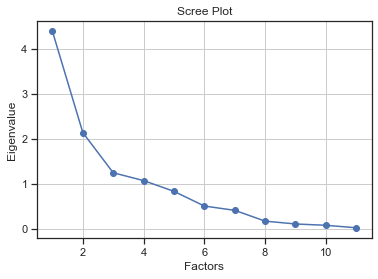

In [66]:
factor_number_tester = FactorAnalyzer(n_factors=10, rotation=None) # Using number of factors = number of columns
factor_number_tester.fit(wellness_df) 
ev, v = factor_number_tester.get_eigenvalues()

plt.scatter(range(1,wellness_df.shape[1]+1),ev)
plt.plot(range(1,wellness_df.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()


It seems like the elbow forms at the second factor so I will use 2 factors for my analysis.

### Perform Factor Analysis

In [67]:
list(wellness_df.columns)

['Fatigue',
 'Soreness',
 'Desire',
 'Irritability',
 'SleepHours',
 'SleepQuality',
 'Pain',
 'Illness',
 'Menstruation',
 'Nutrition',
 'TrainingReadiness']

In [68]:
fa = FactorAnalyzer(n_factors=2, rotation='varimax')

fa.fit(wellness_df)
fa.loadings_


array([[ 0.99912243,  0.1105728 ],
       [ 0.86920447,  0.04992037],
       [ 0.77638185,  0.04543086],
       [ 0.88204344,  0.0039812 ],
       [ 0.19467864,  0.37102141],
       [ 0.79401352,  0.34935473],
       [ 0.04187323,  0.9017677 ],
       [ 0.07112361,  0.76312526],
       [ 0.26668668,  0.21405369],
       [-0.34355545,  0.36428948],
       [ 0.01533894,  0.15368426]])

The rule of thumb for seeing if a observation is related to a factor is a loading of `0.7` or higher.

From this we see that `Fatigue`, `Soreness`, `Desire`, `Irritability`, and `SleepQuality` all relate to the first factor. This is interesting because these are the observations that made up the Monitor Score. We can see this as subjective wellness as they are all self reported values.

The second is related to `Pain` and `Illness`. We can see this as objective wellness.

In [69]:
fa.get_factor_variance()

(array([3.99908803, 1.87419362]),
 array([0.36355346, 0.17038124]),
 array([0.36355346, 0.5339347 ]))

This 2 factor model explains `53.4%` of the variance which is adequate.

#### Try 3 Factors

Some would say that the elbow of the scree plot occurs at the 3rd factor. Just to make sure I should not be using 3 factors, let's see what happens when I do.

In [70]:
fa_alt = FactorAnalyzer(n_factors=3, rotation='varimax')

fa_alt.fit(wellness_df)
fa_alt.loadings_


array([[ 0.99159758,  0.12594136,  0.0501665 ],
       [ 0.86585042,  0.1316575 , -0.13910975],
       [ 0.7677682 ,  0.10837218, -0.07241608],
       [ 0.89122603, -0.04202303,  0.15859535],
       [ 0.1867622 ,  0.36325139,  0.0781631 ],
       [ 0.7938382 ,  0.28225095,  0.26826488],
       [ 0.04249619,  0.73823902,  0.26565282],
       [ 0.02922259,  1.00064846, -0.02013975],
       [ 0.28681749,  0.03944479,  0.51735289],
       [-0.38489098,  0.19208421,  0.7052357 ],
       [ 0.01690412,  0.10581203,  0.11918311]])

In [71]:
fa_alt.get_factor_variance()


(array([4.01512472, 1.85426516, 0.98053334]),
 array([0.36501134, 0.16856956, 0.08913939]),
 array([0.36501134, 0.5335809 , 0.62272029]))

The interpretation of the first two factors has not changed while the last factor is related to `Nutrition`. Given that the 3 factor model explains a higher proportion of the variance in the data compared to the 2 factor model, we could use this model instead.

## Alternative Measure For Sleep

We want to see if we should combine sleep into one measure by multipliying the quality and duration to get a sleep score. We will run factor analysis on this new dataset and see if we get results that explain more of the variance than before.

In [72]:
wellness_df_alt = wellness_df.copy()
wellness_df_alt['SleepScore'] = wellness_df_alt['SleepQuality'] * wellness_df_alt['SleepHours']
wellness_df_alt = wellness_df_alt.drop(columns=['SleepQuality', 'SleepHours'])
wellness_df_alt.head()


,Fatigue,Soreness,Desire,Irritability,Pain,Illness,Menstruation,Nutrition,TrainingReadiness,SleepScore
0,2.671924,3.302839,2.479495,3.936909,0.974763,0.848580,0.842271,2.943218,21.435331,31.479552
1,3.779762,3.276786,4.113095,4.151786,0.794643,0.955357,0.812500,2.669643,11.651786,37.319037
2,3.350725,3.176812,3.455072,3.979710,0.973913,1.000000,0.881159,2.982609,98.115942,30.833648
3,3.305195,3.542208,3.935065,3.668831,0.993506,0.983766,0.853896,2.925325,66.996753,24.422963
4,3.803089,3.814672,4.324324,3.965251,0.683398,0.745174,0.888031,2.050193,65.637066,30.448059


### Choose Number of Factors 

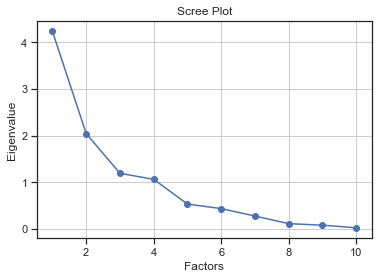

In [73]:
factor_number_tester.fit(wellness_df_alt) 
ev, v = factor_number_tester.get_eigenvalues()

plt.scatter(range(1,wellness_df_alt.shape[1]+1),ev)
plt.plot(range(1,wellness_df_alt.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()


Again, we see that we could use 2 or 3 factors.

### Run Factor Analysis

In [74]:
list(wellness_df_alt.columns)


['Fatigue',
 'Soreness',
 'Desire',
 'Irritability',
 'Pain',
 'Illness',
 'Menstruation',
 'Nutrition',
 'TrainingReadiness',
 'SleepScore']

In [75]:
fa_sleep_score = FactorAnalyzer(n_factors=2, rotation='varimax')

fa_sleep_score.fit(wellness_df_alt)
fa_sleep_score.loadings_


array([[ 1.0051823 ,  0.08074343],
       [ 0.87275937,  0.03950162],
       [ 0.7858624 ,  0.00327206],
       [ 0.87397774, -0.0262532 ],
       [ 0.07429965,  0.95359772],
       [ 0.10655025,  0.71818683],
       [ 0.26869352,  0.22223522],
       [-0.3355373 ,  0.3796943 ],
       [ 0.02297591,  0.16112694],
       [ 0.73832663,  0.33462773]])

In [76]:
fa_sleep_score.get_factor_variance()

(array([3.90082616, 1.7654146 ]),
 array([0.39008262, 0.17654146]),
 array([0.39008262, 0.56662408]))

### With 3 Factors

In [77]:
fa_sleep_score_alt = FactorAnalyzer(n_factors=3, rotation='varimax')

fa_sleep_score_alt.fit(wellness_df_alt)
fa_sleep_score_alt.loadings_


array([[ 0.9991538 ,  0.0749774 ,  0.07501114],
       [ 0.87616229,  0.12011015, -0.13301446],
       [ 0.77875354,  0.056524  , -0.04229131],
       [ 0.88188067, -0.09544697,  0.15606715],
       [ 0.07684542,  0.72661866,  0.30453476],
       [ 0.08301059,  0.99797736,  0.03026167],
       [ 0.2822244 ,  0.00694265,  0.54160426],
       [-0.38129149,  0.18295721,  0.68859803],
       [ 0.02311145,  0.09932467,  0.14013581],
       [ 0.73283312,  0.26393955,  0.24897863]])

In [78]:
fa_sleep_score_alt.get_factor_variance()


(array([3.92554758, 1.66933764, 0.99225304]),
 array([0.39255476, 0.16693376, 0.0992253 ]),
 array([0.39255476, 0.55948852, 0.65871383]))

### Experiment Conclusions

When we create the sleep score, we are making a summary column yet we removed the Monitor Score which is yet another summary column. Even though the model with sleep score explains more variance, does it make sense to do this?

## Factor Analysis Conclusions

Given the wellness data, we can summarize it into summary measures by taking the `Monitor Score` with the categorical variables `Pain` and `Illness`. This gives us as nice 3 feature description of ones wellness. Since the `Monitor Score` is on a different scale than `Pain` and `Illness`, we can standardize the `Monitor Score`.

If we wanted to use the 3 factor model, we could also include `Nutrition` into our model. The question is, so we want to include a variable for which we imputed 17% of the data?

## Summarizing Data

There are two paths we could go down for summarizing the data. The first is to do a linear combination of the terms based on the eiganvalues (need to map everything to the 0-1 scale to do this). Another option is that we could use the built in mapping function in the factor analysis package to map the data to the factors and then add up the values of all the factors for a single wellness score.

Note that we might not actually need a single wellness score if we are looking to use wellness as covariates in some model of performance.

In [79]:
summary_fa = FactorAnalyzer(n_factors=3, rotation='varimax')

summary_fa.fit(wellness_df)
player_wellness_scores = summary_fa.transform(wellness_df)
player_wellness_scores


array([[-1.02835549,  0.23435124,  0.26614023],
       [ 0.40090227,  0.44116824, -0.0394425 ],
       [-0.34126909,  1.13783268,  0.71685714],
       [-0.56866246,  0.20672631,  0.08378882],
       [ 0.59610696, -0.44881622, -1.38997489],
       [ 0.40949238,  0.27951842,  0.4191259 ],
       [-0.62161165,  0.20454614,  0.52991325],
       [ 0.77100818, -2.91526264,  1.19427776],
       [ 1.97844542,  0.49692949,  0.07174446],
       [-0.51778595, -2.26063069, -0.88979599],
       [-1.58750256, -0.48638401,  0.33844993],
       [ 0.55742135,  0.43078627, -1.59308381],
       [-0.32009679,  0.36769832,  1.16745751],
       [-0.50787494,  0.71079902,  0.8971944 ],
       [ 1.70994662,  0.4824574 ,  0.50482537],
       [-1.87763014,  0.61206614, -1.37757384],
       [ 0.9474659 ,  0.50621389, -0.89990375]])

In [80]:
wellness_df['PlayerID'] = player_id_series
wellness_df['SubjectiveWellBeing'] = player_wellness_scores[:, 0]
wellness_df['PhysicalHealth'] = player_wellness_scores[:, 1]
wellness_df['Nutrition2'] = player_wellness_scores[:, 2]
wellness_df['AverageMonitoringScore'] = wellness_df['Fatigue'] + wellness_df['Soreness'] + wellness_df['Desire'] + wellness_df['Irritability'] + wellness_df['SleepQuality']
wellness_df['OverallWellness'] = wellness_df['SubjectiveWellBeing'] + wellness_df['PhysicalHealth'] + wellness_df['Nutrition']
wellness_df


,Fatigue,Soreness,Desire,Irritability,SleepHours,SleepQuality,Pain,Illness,Menstruation,Nutrition,TrainingReadiness,PlayerID,SubjectiveWellBeing,PhysicalHealth,Nutrition2,AverageMonitoringScore,OverallWellness
0,2.671924,3.302839,2.479495,3.936909,8.715300,3.611987,0.974763,0.848580,0.842271,2.943218,21.435331,1,-1.028355,0.234351,0.266140,16.003155,2.149213
1,3.779762,3.276786,4.113095,4.151786,9.053571,4.122024,0.794643,0.955357,0.812500,2.669643,11.651786,2,0.400902,0.441168,-0.039443,19.443452,3.511713
2,3.350725,3.176812,3.455072,3.979710,7.879710,3.913043,0.973913,1.000000,0.881159,2.982609,98.115942,3,-0.341269,1.137833,0.716857,17.875362,3.779172
3,3.305195,3.542208,3.935065,3.668831,8.266234,2.954545,0.993506,0.983766,0.853896,2.925325,66.996753,4,-0.568662,0.206726,0.083789,17.405844,2.563389
4,3.803089,3.814672,4.324324,3.965251,7.925676,3.841699,0.683398,0.745174,0.888031,2.050193,65.637066,5,0.596107,-0.448816,-1.389975,19.749035,2.197484
5,3.694656,3.438931,3.961832,3.942748,8.471374,3.984733,0.996183,0.942748,0.858779,2.740458,67.156489,6,0.409492,0.279518,0.419126,19.022901,3.429469
6,3.073314,3.087977,3.797654,3.697947,9.212610,3.862170,0.929619,0.903226,0.868035,2.888563,93.460411,7,-0.621612,0.204546,0.529913,17.519062,2.471498
7,3.737705,3.537705,3.734426,4.367213,8.194262,4.016393,0.744262,0.291803,0.927869,2.531148,53.704918,8,0.771008,-2.915263,1.194278,19.393443,0.386893
8,4.877828,4.565611,4.886878,4.914027,9.160633,4.900452,0.995475,0.941176,0.895928,2.479638,77.104072,9,1.978445,0.496929,0.071744,24.144796,4.955013
9,2.954683,2.978852,3.794562,3.824773,8.374622,2.933535,0.274924,0.404834,0.788520,2.513595,74.244713,10,-0.517786,-2.260631,-0.889796,16.486405,-0.264821


It is strange that the features and the mapping to the 3 factors do not seem to match up very well. 

In [81]:
wellness_df['SubjectiveWellBeing'].corr(wellness_df['AverageMonitoringScore'])

0.9370895198561597

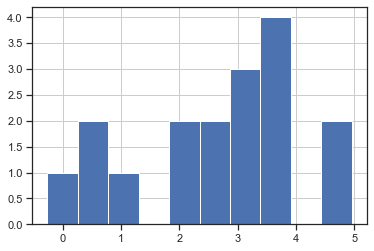

In [82]:
wellness_df['OverallWellness'].hist()

## Final Thoughts

We could attach the wellness scores to each player but I am unsure about the validity of doing so. I think a better idea would be to just use the seperate features that we found to be relevant from wellness. These were, `MonitorScore`, `Illness`, `Pain`, and (potentially) `Nutrition`.

## Next Steps

This notebook is getting quite long so I should stop here. The general conclusions are that the wellness data can be summarized using the `MonitoringScore`, `Pain`, `Illness`, and `Nutrition` data. I tried to transform the data to the factors, the relationships between columns that are correlated to a factor and the value of the factor itself seemed to break down.

Going forward, I want to improve my imputing on the nutrition data by sampling from the nutrition data from the given player. I also want to try and summarize the wellness data using normalized scores for each of the key features mentioned above because the scales are different.

## PCA down to 2 Dimensions

I want to try and visualize the clusters of players so I will use PCA to plot the average player wellness data on 2 principal components.

In [83]:
pca_df.head()

,Fatigue,Soreness,Desire,Irritability,SleepHours,SleepQuality,Pain,Illness,Menstruation,Nutrition,TrainingReadiness
0,2.671924,3.302839,2.479495,3.936909,8.715300,3.611987,0.974763,0.848580,0.842271,2.943218,21.435331
1,3.779762,3.276786,4.113095,4.151786,9.053571,4.122024,0.794643,0.955357,0.812500,2.669643,11.651786
2,3.350725,3.176812,3.455072,3.979710,7.879710,3.913043,0.973913,1.000000,0.881159,2.982609,98.115942
3,3.305195,3.542208,3.935065,3.668831,8.266234,2.954545,0.993506,0.983766,0.853896,2.925325,66.996753
4,3.803089,3.814672,4.324324,3.965251,7.925676,3.841699,0.683398,0.745174,0.888031,2.050193,65.637066


In [84]:
pca_standard_scaler = StandardScaler()
pca_df[pca_df.columns] = pca_standard_scaler.fit_transform(pca_df)
pca_df

,Fatigue,Soreness,Desire,Irritability,SleepHours,SleepQuality,Pain,Illness,Menstruation,Nutrition,TrainingReadiness
0,-1.367946,-0.245809,-2.728568,-0.196525,0.075544,-0.405559,0.468923,0.019135,-0.307996,1.116527,-2.035719
1,0.484052,-0.301253,0.443991,0.438675,0.782637,0.377043,-0.529892,0.564711,-0.859682,0.183802,-2.447402
2,-0.233180,-0.514008,-0.833933,-0.069999,-1.671097,0.056383,0.464208,0.792814,0.412632,1.250827,1.190932
3,-0.309293,0.263590,0.098244,-0.988991,-0.863143,-1.414341,0.572859,0.709867,-0.092579,1.055523,-0.118535
4,0.523049,0.843420,0.854211,-0.112742,-1.575015,-0.053089,-1.146776,-0.509222,0.539966,-1.928148,-0.175750
5,0.341780,0.043808,0.150228,-0.179263,-0.434336,0.166383,0.587702,0.500285,-0.002102,0.425239,-0.111814
6,-0.696934,-0.703057,-0.168617,-0.902921,1.115077,-0.021678,0.218585,0.298346,0.169429,0.930188,0.995032
7,0.413745,0.254008,-0.291409,1.075502,-1.013586,0.214963,-0.809266,-2.825721,1.278195,-0.288383,-0.677844
8,2.319716,2.441490,1.946727,2.691944,1.006430,1.571468,0.583775,0.492255,0.686298,-0.464000,0.306772
9,-0.895252,-0.935285,-0.174622,-0.528009,-0.636577,-1.446580,-3.411868,-2.248191,-1.304058,-0.348226,0.186452


In [85]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(pca_df)
principal_components


array([[-2.24626943e+00, -8.50789204e-01],
       [ 4.84595029e-01,  3.15506895e-01],
       [-8.09180072e-01, -1.18937483e+00],
       [-1.13277294e+00, -8.48327103e-01],
       [ 7.37181158e-01,  2.40472337e+00],
       [ 2.41415771e-01, -6.19545584e-01],
       [-8.79959960e-01, -1.52155287e+00],
       [ 3.24560019e-01,  2.45686288e+00],
       [ 5.12654257e+00,  1.85017672e-01],
       [-2.71909500e+00,  3.46914904e+00],
       [-3.03301936e+00, -6.13182606e-01],
       [ 6.96639181e-01,  8.54504879e-01],
       [ 4.39156514e-03, -1.55051296e+00],
       [ 2.72094559e-01, -1.71283676e+00],
       [ 4.09417198e+00, -1.52419865e-01],
       [-2.17377948e+00, -4.54729650e-03],
       [ 1.01248442e+00, -6.22675657e-01]])

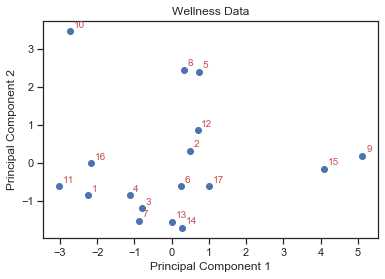

In [89]:
HORIZONTAL_OFFSET = 0.1
VERTICAL_OFFSET = 0.1

fig, ax = plt.subplots()
ax.scatter(principal_components[:, 0], principal_components[:, 1])
plt.title('Wellness Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')


for i in range(len(player_id_series)):
    ax.annotate(str(i + 1), (principal_components[i, 0] + HORIZONTAL_OFFSET, principal_components[i, 1] + VERTICAL_OFFSET), color='r')
plt.show()

We see that 15 and 9 are similar and outliers

1 and 2 are outliers seperatly

12, 5, 6, 14, and 8 are similar and moderate

13, 3, and 7 form their own cluster

10, 4, and 16 are clustered,

11 is on its own

17 is between two clusters